# How to transform data into factors

Based on a conceptual understanding of key factor categories, their rationale and popular metrics, a key task is to identify new factors that may better capture the risks embodied by the return drivers laid out previously, or to find new ones. 

In either case, it will be important to compare the performance of innovative factors to that of known factors to identify incremental signal gains.

We create the dataset here and store it in our [data](../../data) folder to facilitate reuse in later chapters.

## Imports & Settings

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline

from datetime import datetime
import pandas as pd
import pandas_datareader.data as web
from sklearn.preprocessing import scale
# replaces pyfinance.ols.PandasRollingOLS (no longer maintained)
from statsmodels.regression.rolling import RollingOLS
import statsmodels.api as sm

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
sns.set_style('whitegrid')
idx = pd.IndexSlice

In [4]:
import yfinance as yf

## Get Data

The `assets.h5` store can be generated using the the notebook [create_datasets](../../data/create_datasets.ipynb) in the [data](../../data) directory in the root directory of this repo for instruction to download the following dataset.

We load the Quandl stock price datasets covering the US equity markets 2000-18 using `pd.IndexSlice` to perform a slice operation on the `pd.MultiIndex`, select the adjusted close price and unpivot the column to convert the DataFrame to wide format with tickers in the columns and timestamps in the rows:

Set data store location:

# Otros Settings iniciales

In [104]:
normaliza=True #normalizamos por volatilidad
neutraliza=False #normalizado cross sectional media y vola

In [107]:
DATA_STORE = 'data/assets.parquet'

In [108]:
START = 2004
END = 2024

In [174]:

ticker_list = ['XLE', 'XLB', 'XLI', 'XLK', 'XLF', 
               'XLP', 'XLY', 'XLV', 'XLU', 'IYR', 'VOX', 'SPY']
 
# Here we use yf.download function
data = yf.download(
     
    # passes the ticker
    tickers=ticker_list,
     
    # used for access data[ticker]
    group_by='ticker',
 
)

[*********************100%***********************]  12 of 12 completed


In [175]:
#apilamos tickers
data = (data
                .stack(-2))
data

Price                                   Open        High         Low  \
Date                      Ticker                                       
1993-01-29 00:00:00+00:00 SPY      43.968750   43.968750   43.750000   
1993-02-01 00:00:00+00:00 SPY      43.968750   44.250000   43.968750   
1993-02-02 00:00:00+00:00 SPY      44.218750   44.375000   44.125000   
1993-02-03 00:00:00+00:00 SPY      44.406250   44.843750   44.375000   
1993-02-04 00:00:00+00:00 SPY      44.968750   45.093750   44.468750   
...                                      ...         ...         ...   
2024-11-08 00:00:00+00:00 XLK     237.119995  237.940002  236.300003   
                          XLP      79.860001   81.019997   79.849998   
                          XLU      78.080002   79.349998   78.019997   
                          XLV     149.309998  150.949997  149.139999   
                          XLY     212.080002  216.270004  211.850006   

Price                                  Close   Adj Close      Volume  
Date                      Ticker                                      
1993-01-29 00:00:00+00:00 SPY      43.937500   24.608622   1003200.0  
1993-02-01 00:00:00+00:00 SPY      44.250000   24.783638    480500.0  
1993-02-02 00:00:00+00:00 SPY      44.343750   24.836157    201300.0  
1993-02-03 00:00:00+00:00 SPY      44.812500   25.098682    529400.0  
1993-02-04 00:00:00+00:00 SPY      45.000000   25.203712    531500.0  
...                                      ...         ...         ...  
2024-11-08 00:00:00+00:00 XLK     237.160004  237.160004   3617100.0  
                          XLP      80.820000   80.820000  11530300.0  
                          XLU      79.180000   79.180000  14404900.0  
                          XLV     150.179993  150.179993   8700300.0  
                          XLY     215.119995  215.119995   3892900.0  

[77822 rows x 6 columns]

In [176]:
data = data.rename_axis(['date', 'ticker'])

In [177]:
data.head()

,Price,Open,High,Low,Close,Adj Close,Volume
date,ticker,,,,,,
1993-01-29 00:00:00+00:00,SPY,43.96875,43.96875,43.75000,43.93750,24.608622,1003200.0
1993-02-01 00:00:00+00:00,SPY,43.96875,44.25000,43.96875,44.25000,24.783638,480500.0
1993-02-02 00:00:00+00:00,SPY,44.21875,44.37500,44.12500,44.34375,24.836157,201300.0
1993-02-03 00:00:00+00:00,SPY,44.40625,44.84375,44.37500,44.81250,25.098682,529400.0
1993-02-04 00:00:00+00:00,SPY,44.96875,45.09375,44.46875,45.00000,25.203712,531500.0


In [178]:
# Reordenar y renombrar las columnas directamente
new_order = ['Open', 'High', 'Low','Close','Volume', 'Adj Close']
new_names = ['open', 'high', 'low','close','volume', 'Adj Close']

# Reordenar las columnas
prices = data[new_order]

# Renombrar las columnas
prices.columns = new_names


In [179]:
prices.head()

,,open,high,low,close,volume,Adj Close
date,ticker,,,,,,
1993-01-29 00:00:00+00:00,SPY,43.96875,43.96875,43.75000,43.93750,1003200.0,24.608622
1993-02-01 00:00:00+00:00,SPY,43.96875,44.25000,43.96875,44.25000,480500.0,24.783638
1993-02-02 00:00:00+00:00,SPY,44.21875,44.37500,44.12500,44.34375,201300.0,24.836157
1993-02-03 00:00:00+00:00,SPY,44.40625,44.84375,44.37500,44.81250,529400.0,25.098682
1993-02-04 00:00:00+00:00,SPY,44.96875,45.09375,44.46875,45.00000,531500.0,25.203712


In [180]:
prices=prices.sort_index()


In [181]:
# Crear un nuevo DataFrame sin entradas duplicadas en el índice
prices = prices.loc[~prices.index.duplicated(keep='first')]


In [182]:
prices.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 77822 entries, (Timestamp('1993-01-29 00:00:00+0000', tz='UTC'), 'SPY') to (Timestamp('2024-11-08 00:00:00+0000', tz='UTC'), 'XLY')
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   open       77822 non-null  float64
 1   high       77822 non-null  float64
 2   low        77822 non-null  float64
 3   close      77822 non-null  float64
 4   volume     77822 non-null  float64
 5   Adj Close  77822 non-null  float64
dtypes: float64(6)
memory usage: 4.1+ MB


In [183]:
# Suponiendo que 'df' es tu DataFrame
num_ticker = prices.index.get_level_values('ticker').nunique()

print(f'El índice "ticker" tiene {num_ticker} elementos únicos.')


El índice "ticker" tiene 12 elementos únicos.


In [184]:
prices.tail()

open        high         low  \
date                      ticker                                       
2024-11-08 00:00:00+00:00 XLK     237.119995  237.940002  236.300003   
                          XLP      79.860001   81.019997   79.849998   
                          XLU      78.080002   79.349998   78.019997   
                          XLV     149.309998  150.949997  149.139999   
                          XLY     212.080002  216.270004  211.850006   

                                       close      volume   Adj Close  
date                      ticker                                      
2024-11-08 00:00:00+00:00 XLK     237.160004   3617100.0  237.160004  
                          XLP      80.820000  11530300.0   80.820000  
                          XLU      79.180000  14404900.0   79.180000  
                          XLV     150.179993   8700300.0  150.179993  
                          XLY     215.119995   3892900.0  215.119995

## eliminamos spy

In [185]:
prices = prices.swaplevel(0, 1)

In [186]:
prices.index

MultiIndex([('SPY', '1993-01-29 00:00:00+00:00'),
            ('SPY', '1993-02-01 00:00:00+00:00'),
            ('SPY', '1993-02-02 00:00:00+00:00'),
            ('SPY', '1993-02-03 00:00:00+00:00'),
            ('SPY', '1993-02-04 00:00:00+00:00'),
            ('SPY', '1993-02-05 00:00:00+00:00'),
            ('SPY', '1993-02-08 00:00:00+00:00'),
            ('SPY', '1993-02-09 00:00:00+00:00'),
            ('SPY', '1993-02-10 00:00:00+00:00'),
            ('SPY', '1993-02-11 00:00:00+00:00'),
            ...
            ('VOX', '2024-11-08 00:00:00+00:00'),
            ('XLB', '2024-11-08 00:00:00+00:00'),
            ('XLE', '2024-11-08 00:00:00+00:00'),
            ('XLF', '2024-11-08 00:00:00+00:00'),
            ('XLI', '2024-11-08 00:00:00+00:00'),
            ('XLK', '2024-11-08 00:00:00+00:00'),
            ('XLP', '2024-11-08 00:00:00+00:00'),
            ('XLU', '2024-11-08 00:00:00+00:00'),
            ('XLV', '2024-11-08 00:00:00+00:00'),
            ('XLY', '2024-11-08 00

In [187]:
#eliminamos spy
prices = prices.drop(index='SPY', level=0)


In [188]:
prices = prices.sort_index(level=list(range(len(prices.index.names))))  # Sort all levels

In [189]:
# Convert the index to standard dtypes before saving
# prices_to_save = prices.copy()
# prices_to_save.index = prices_to_save.index.set_levels([
#     level.astype(object) for level in prices_to_save.index.levels
# ])

# with pd.HDFStore(DATA_STORE) as store:
#     store.put('data_close', prices_to_save.sort_index())
#     print(store.info())

prices.to_parquet('data/prices.parquet')

In [190]:
#hacemos unstack de close sólo
prices= (prices.loc[idx[:,str(START):str(END)], 'close']
              .unstack('ticker'))

In [191]:
prices.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5250 entries, 2004-01-02 00:00:00+00:00 to 2024-11-08 00:00:00+00:00
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   IYR     5250 non-null   float64
 1   VOX     5064 non-null   float64
 2   XLB     5250 non-null   float64
 3   XLE     5250 non-null   float64
 4   XLF     5250 non-null   float64
 5   XLI     5250 non-null   float64
 6   XLK     5250 non-null   float64
 7   XLP     5250 non-null   float64
 8   XLU     5250 non-null   float64
 9   XLV     5250 non-null   float64
 10  XLY     5250 non-null   float64
dtypes: float64(11)
memory usage: 492.2 KB


In [194]:
prices

ticker,IYR,VOX,XLB,XLE,XLF,XLI,XLK,XLP,XLU,XLV,XLY
date,,,,,,,,,,,
2004-01-02 00:00:00+00:00,49.490002,NaN,26.559999,27.540001,22.818846,26.740000,20.480000,21.520000,23.270000,30.219999,31.219999
2004-01-05 00:00:00+00:00,49.509998,NaN,27.100000,28.070000,23.005686,27.000000,20.980000,21.660000,23.309999,30.360001,31.490000
2004-01-06 00:00:00+00:00,49.599998,NaN,26.860001,28.040001,22.997562,26.959999,21.170000,21.709999,23.260000,30.450001,31.610001
2004-01-07 00:00:00+00:00,49.380001,NaN,26.719999,27.750000,23.013809,27.000000,21.270000,21.620001,23.379999,30.639999,31.750000
2004-01-08 00:00:00+00:00,49.480000,NaN,27.020000,27.830000,23.095045,27.170000,21.690001,21.590000,23.370001,30.510000,31.650000
...,...,...,...,...,...,...,...,...,...,...,...
2024-11-04 00:00:00+00:00,98.250000,147.699997,93.540001,89.570000,46.279999,133.860001,223.740005,80.370003,77.199997,146.770004,199.399994
2024-11-05 00:00:00+00:00,99.589996,149.399994,93.680000,90.169998,46.709999,136.100006,226.889999,80.879997,78.360001,147.850006,202.929993
2024-11-06 00:00:00+00:00,97.080002,153.169998,94.970001,93.559998,49.549999,141.429993,233.350006,79.559998,77.550003,148.039993,209.419998


In [196]:
tiene_indices_duplicados = prices.index.duplicated().any()


### Keep data with stock info

Remove `stocks` duplicates and align index names for later joining.

In [197]:
"""stocks = stocks[~stocks.index.duplicated()]
stocks.index.name = 'ticker'"""

"stocks = stocks[~stocks.index.duplicated()]\nstocks.index.name = 'ticker'"

Get tickers with both price information and metdata

In [29]:
"""shared = prices.columns.intersection(stocks.index)"""

'shared = prices.columns.intersection(stocks.index)'

In [30]:
#stocks = stocks.loc[shared, :]
#stocks.info()

In [31]:
#prices = prices.loc[:, shared]
#prices.info()

In [32]:
#assert prices.shape[1] == stocks.shape[0]

## Create monthly/weekly return series

To reduce training time and experiment with strategies for longer time horizons, we convert the business-daily data to month-end frequency using the available adjusted close price:

In [198]:
#monthly_prices = prices.resample('M').last()
weekly_prices = prices.resample('W').last()
#monthly_prices = prices.resample('W-WED').last() #final en miercoles

To capture time series dynamics that reflect, for example, momentum patterns, we compute historical returns using the method `.pct_change(n_periods)`, that is, returns over various monthly periods as identified by lags.

We then convert the wide result back to long format with the `.stack()` method, use `.pipe()` to apply the `.clip()` method to the resulting `DataFrame`, and winsorize returns at the [1%, 99%] levels; that is, we cap outliers at these percentiles.

Finally, we normalize returns using the geometric average. After using `.swaplevel()` to change the order of the `MultiIndex` levels, we obtain compounded monthly returns for six periods ranging from 1 to 12 months:

In [199]:
weekly_prices.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1089 entries, 2004-01-04 00:00:00+00:00 to 2024-11-10 00:00:00+00:00
Freq: W-SUN
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   IYR     1089 non-null   float64
 1   VOX     1050 non-null   float64
 2   XLB     1089 non-null   float64
 3   XLE     1089 non-null   float64
 4   XLF     1089 non-null   float64
 5   XLI     1089 non-null   float64
 6   XLK     1089 non-null   float64
 7   XLP     1089 non-null   float64
 8   XLU     1089 non-null   float64
 9   XLV     1089 non-null   float64
 10  XLY     1089 non-null   float64
dtypes: float64(11)
memory usage: 102.1 KB


In [200]:
outlier_cutoff = 0.01
data = pd.DataFrame()
#lags = [1, 2, 3, 6,9, 12]
lags = [1, 2, 3, 6, 12, 52] #para semanas
for lag in lags:
    data[f'return_{lag:02d}w'] = (weekly_prices
                           .pct_change(lag)
                           .stack()
                           .pipe(lambda x: x.clip(lower=x.quantile(outlier_cutoff),
                                                  upper=x.quantile(1-outlier_cutoff)))
                           .add(1)
                           .pow(1/lag)
                           .sub(1)
                           )
data = data.swaplevel().dropna()
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 11368 entries, ('IYR', Timestamp('2005-01-02 00:00:00+0000', tz='UTC')) to ('XLY', Timestamp('2024-11-10 00:00:00+0000', tz='UTC'))
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   return_01w  11368 non-null  float64
 1   return_02w  11368 non-null  float64
 2   return_03w  11368 non-null  float64
 3   return_06w  11368 non-null  float64
 4   return_12w  11368 non-null  float64
 5   return_52w  11368 non-null  float64
dtypes: float64(6)
memory usage: 607.5+ KB


In [201]:
data.head()

,,return_01w,return_02w,return_03w,return_06w,return_12w,return_52w
ticker,date,,,,,,
IYR,2005-01-02 00:00:00+00:00,0.013158,0.001057,0.000569,0.011399,0.009100,0.004218
XLB,2005-01-02 00:00:00+00:00,-0.003018,0.008172,0.008437,0.004499,0.006063,0.002171
XLE,2005-01-02 00:00:00+00:00,-0.005204,0.003738,0.007168,-0.000275,0.000299,0.005336
XLF,2005-01-02 00:00:00+00:00,-0.001635,0.008627,0.005408,0.006935,0.004728,0.001603
XLI,2005-01-02 00:00:00+00:00,-0.005760,0.002423,0.002371,0.003860,0.007605,0.002890


## Drop stocks with less than 10 yrs of returns

In [204]:
#min_obs = 12*10 #mensual
min_obs = 52*10 #semanal
nobs = data.groupby(level='ticker').size()
keep = nobs[nobs>min_obs].index

data = data.loc[idx[keep,:], :]
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 11368 entries, ('IYR', Timestamp('2005-01-02 00:00:00+0000', tz='UTC')) to ('XLY', Timestamp('2024-11-10 00:00:00+0000', tz='UTC'))
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   return_01w  11368 non-null  float64
 1   return_02w  11368 non-null  float64
 2   return_03w  11368 non-null  float64
 3   return_06w  11368 non-null  float64
 4   return_12w  11368 non-null  float64
 5   return_52w  11368 non-null  float64
dtypes: float64(6)
memory usage: 607.5+ KB


In [205]:
data.describe()

,return_01w,return_02w,return_03w,return_06w,return_12w,return_52w
count,11368.000000,11368.000000,11368.000000,11368.000000,11368.000000,11368.000000
mean,0.001713,0.001555,0.001473,0.001375,0.001309,0.001229
std,0.026506,0.018095,0.014748,0.010221,0.007112,0.003601
min,-0.081635,-0.058857,-0.050029,-0.036302,-0.026527,-0.011747
25%,-0.012235,-0.007596,-0.005723,-0.003661,-0.001840,-0.000224
50%,0.002741,0.002733,0.002622,0.002342,0.002108,0.001656
75%,0.016706,0.012195,0.010139,0.007554,0.005635,0.003352
max,0.078079,0.048884,0.039554,0.026431,0.016980,0.009128


In [206]:
data2=data.copy()

## Nomalizado de retornos

In [207]:
def normalize_by_rolling_std(series):
    return series / series.rolling(52).std().shift(1)

In [208]:
#normaliza=True

In [209]:
if normaliza==True:
    lags = [1, 2, 3, 6, 12, 52] #para semanas
    for lag in lags:
           data[f'return_{lag:02d}w'] = (data.groupby(level='ticker')[f'return_{lag:02d}w']
                             .transform(normalize_by_rolling_std)
                             )

In [210]:
# Función para neutralizar (normalizar) los retornos por cada fecha
def neutralize(group):
    return (group - group.mean()) / group.std()


In [211]:
#neutraliza=True

In [212]:
if neutraliza==True:
    lags = [1, 2, 3, 6, 12, 52] #para semanas
    for lag in lags:
           data[f'return_{lag:02d}m'] = (data.groupby(level='date')[f'return_{lag:02d}m']
                             .transform(neutralize))

In [213]:
data.tail(20)

return_01w  return_02w  return_03w  \
ticker date                                                            
XLY    2024-06-30 00:00:00+00:00   -0.047403    0.683138    0.653995   
       2024-07-07 00:00:00+00:00    1.574767    1.092117    1.507304   
       2024-07-14 00:00:00+00:00    0.471619    1.472156    1.175967   
       2024-07-21 00:00:00+00:00   -0.794446   -0.233045    0.725001   
       2024-07-28 00:00:00+00:00   -1.147500   -1.385236   -0.879902   
       2024-08-04 00:00:00+00:00   -1.444783   -1.825159   -2.006938   
       2024-08-11 00:00:00+00:00   -0.414130   -1.282200   -1.724311   
       2024-08-18 00:00:00+00:00    2.021228    1.081162    0.064756   
       2024-08-25 00:00:00+00:00    1.029587    2.127463    1.511159   
       2024-09-01 00:00:00+00:00   -0.157715    0.587566    1.649003   
       2024-09-08 00:00:00+00:00   -1.007951   -0.801897   -0.090000   
       2024-09-15 00:00:00+00:00    2.184932    0.773602    0.551028   
       2024-09-22 00:00:00+00:00    0.832621    2.082705    1.144432   
       2024-09-29 00:00:00+00:00    0.854322    1.144538    2.245580   
       2024-10-06 00:00:00+00:00   -0.536024    0.205592    0.655934   
       2024-10-13 00:00:00+00:00   -0.322125   -0.584217   -0.012906   
       2024-10-20 00:00:00+00:00    0.598962    0.184331   -0.153487   
       2024-10-27 00:00:00+00:00    0.272775    0.603609    0.314754   
       2024-11-03 00:00:00+00:00   -0.151096    0.085199    0.439005   
       2024-11-10 00:00:00+00:00    3.429767    2.088425    1.887324   

                                  return_06w  return_12w  return_52w  
ticker date                                                           
XLY    2024-06-30 00:00:00+00:00    0.355456    0.260821    0.887042  
       2024-07-07 00:00:00+00:00    1.357048    0.907410    1.369617  
       2024-07-14 00:00:00+00:00    1.547611    1.680513    1.111363  
       2024-07-21 00:00:00+00:00    1.028702    0.932692    1.149164  
       2024-07-28 00:00:00+00:00    0.438427    0.380426    0.677845  
       2024-08-04 00:00:00+00:00   -0.662713   -0.165951    0.323751  
       2024-08-11 00:00:00+00:00   -0.828524   -0.387106    0.326085  
       2024-08-18 00:00:00+00:00   -0.602550    0.676073    1.456642  
       2024-08-25 00:00:00+00:00   -0.348187    1.051033    1.702277  
       2024-09-01 00:00:00+00:00   -0.068124    0.829989    1.294671  
       2024-09-08 00:00:00+00:00   -0.021310    0.360551    1.030841  
       2024-09-15 00:00:00+00:00    1.658529    0.842135    1.536506  
       2024-09-22 00:00:00+00:00    2.218277    1.205509    2.730117  
       2024-09-29 00:00:00+00:00    1.653532    0.951219    3.022006  
       2024-10-06 00:00:00+00:00    0.937591    0.556496    2.857463  
       2024-10-13 00:00:00+00:00    0.867230    0.765330    2.879142  
       2024-10-20 00:00:00+00:00    1.611845    1.528420    3.700774  
       2024-10-27 00:00:00+00:00    0.787833    2.428620    3.965846  
       2024-11-03 00:00:00+00:00    0.350318    2.748245    3.008444  
       2024-11-10 00:00:00+00:00    1.415381    3.212908    3.877569

In [214]:
data2.tail(20)

return_01w  return_02w  return_03w  \
ticker date                                                            
XLY    2024-06-30 00:00:00+00:00   -0.001150    0.011347    0.008815   
       2024-07-07 00:00:00+00:00    0.037829    0.018153    0.020098   
       2024-07-14 00:00:00+00:00    0.011569    0.024615    0.015954   
       2024-07-21 00:00:00+00:00   -0.019218   -0.003943    0.009791   
       2024-07-28 00:00:00+00:00   -0.027688   -0.023462   -0.011922   
       2024-08-04 00:00:00+00:00   -0.035321   -0.031512   -0.027431   
       2024-08-11 00:00:00+00:00   -0.010332   -0.022906   -0.024503   
       2024-08-18 00:00:00+00:00    0.050419    0.019591    0.000948   
       2024-08-25 00:00:00+00:00    0.025883    0.038078    0.021684   
       2024-09-01 00:00:00+00:00   -0.003992    0.010835    0.023861   
       2024-09-08 00:00:00+00:00   -0.025224   -0.014665   -0.001331   
       2024-09-15 00:00:00+00:00    0.055263    0.014221    0.008113   
       2024-09-22 00:00:00+00:00    0.021872    0.038434    0.016765   
       2024-09-29 00:00:00+00:00    0.021099    0.021486    0.032623   
       2024-10-06 00:00:00+00:00   -0.013294    0.003755    0.009758   
       2024-10-13 00:00:00+00:00   -0.008023   -0.010662   -0.000186   
       2024-10-20 00:00:00+00:00    0.014905    0.003375   -0.002212   
       2024-10-27 00:00:00+00:00    0.006516    0.010702    0.004421   
       2024-11-03 00:00:00+00:00   -0.003585    0.001453    0.005917   
       2024-11-10 00:00:00+00:00    0.075116    0.035018    0.025428   

                                  return_06w  return_12w  return_52w  
ticker date                                                           
XLY    2024-06-30 00:00:00+00:00    0.003421    0.001644    0.001376  
       2024-07-07 00:00:00+00:00    0.012657    0.005562    0.002142  
       2024-07-14 00:00:00+00:00    0.014187    0.010088    0.001742  
       2024-07-21 00:00:00+00:00    0.009303    0.005470    0.001807  
       2024-07-28 00:00:00+00:00    0.003961    0.002175    0.001067  
       2024-08-04 00:00:00+00:00   -0.005975   -0.000912    0.000510  
       2024-08-11 00:00:00+00:00   -0.007504   -0.002056    0.000517  
       2024-08-18 00:00:00+00:00   -0.005508    0.003534    0.002282  
       2024-08-25 00:00:00+00:00   -0.003176    0.005468    0.002539  
       2024-09-01 00:00:00+00:00   -0.000613    0.004333    0.001884  
       2024-09-08 00:00:00+00:00   -0.000192    0.001882    0.001497  
       2024-09-15 00:00:00+00:00    0.014876    0.004396    0.002189  
       2024-09-22 00:00:00+00:00    0.020307    0.006305    0.003866  
       2024-09-29 00:00:00+00:00    0.015504    0.004943    0.004263  
       2024-10-06 00:00:00+00:00    0.008936    0.002862    0.004049  
       2024-10-13 00:00:00+00:00    0.008254    0.003810    0.004092  
       2024-10-20 00:00:00+00:00    0.015056    0.007403    0.005284  
       2024-10-27 00:00:00+00:00    0.007086    0.010974    0.005679  
       2024-11-03 00:00:00+00:00    0.002860    0.011546    0.004283  
       2024-11-10 00:00:00+00:00    0.011514    0.013507    0.005540

In [216]:
# #creamos diferencias de retornos con spy
# df_SPY = data.loc['SPY.US']
# new_df = pd.DataFrame()
# for ticker in data.index.get_level_values(0).unique():
#     if ticker != 'SPY.US':
#         df_temp = data.loc[ticker] - df_SPY
#         df_temp['ticker'] = ticker
#         new_df = pd.concat([new_df, df_temp])

# new_df.set_index('ticker', append=True, inplace=True)
# new_df = new_df.reorder_levels(['ticker', 'date'])

In [48]:
#new_df

## Si queremos cambiar el target a excess return


In [49]:
#data=new_df # si queremos cambiar el target a excess retur


In [217]:
data.index.get_level_values(0).unique()

Index(['IYR', 'VOX', 'XLB', 'XLE', 'XLF', 'XLI', 'XLK', 'XLP', 'XLU', 'XLV',
       'XLY'],
      dtype='object', name='ticker')

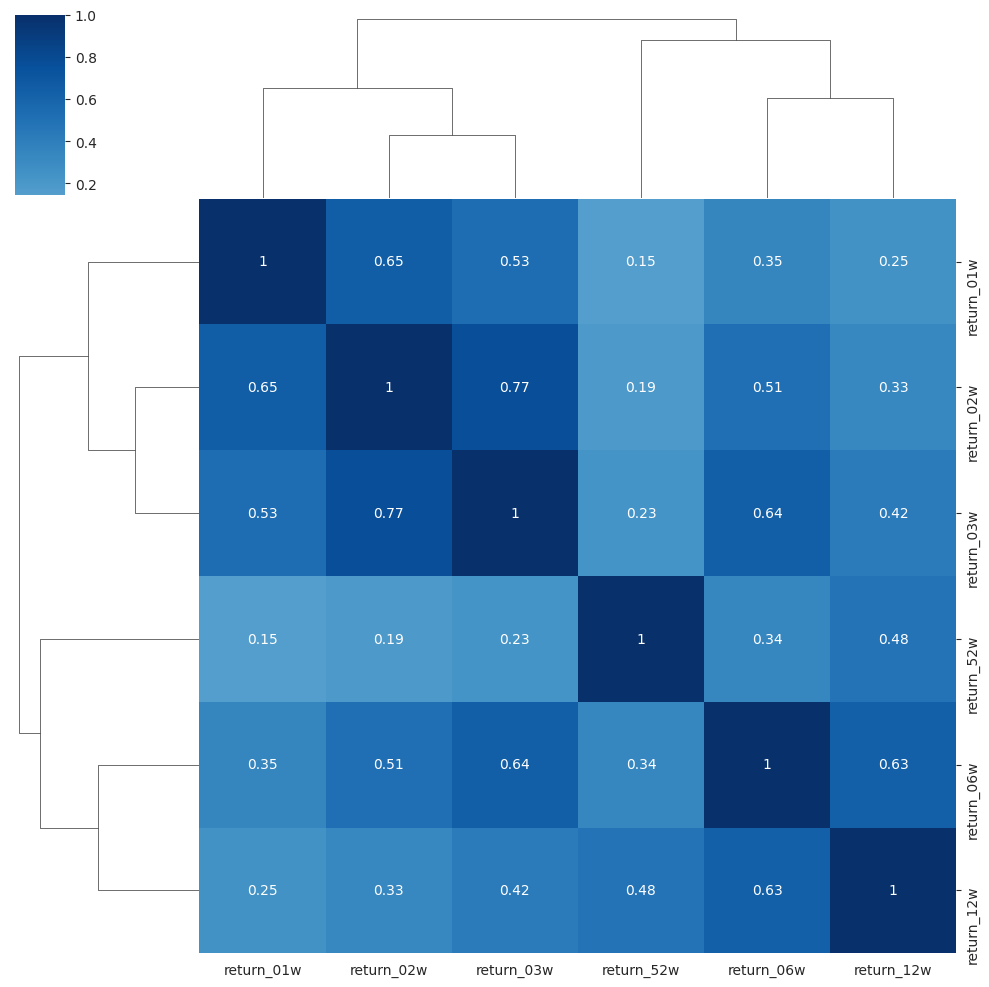

In [51]:
# cmap = sns.diverging_palette(10, 220, as_cmap=True)
sns.clustermap(data.corr('spearman'), annot=True, center=0, cmap='Blues');

In [218]:
data.index.get_level_values('ticker').nunique()

11

## Rolling Factor Betas

We will introduce the Fama—French data to estimate the exposure of assets to common risk factors using linear regression in [Chapter 8, Time Series Models]([](../../08_time_series_models)).

The five Fama—French factors, namely market risk, size, value, operating profitability, and investment have been shown empirically to explain asset returns and are commonly used to assess the risk/return profile of portfolios. Hence, it is natural to include past factor exposures as financial features in models that aim to predict future returns.

We can access the historical factor returns using the `pandas-datareader` and estimate historical exposures using the `PandasRollingOLS` rolling linear regression functionality in the `pyfinance` library as follows:

Use Fama-French research factors to estimate the factor exposures of the stock in the dataset to the 5 factors market risk, size, value, operating profitability and investment.


**Factores de Fama-French**:
1. Mkt-RF (Factor de Riesgo de Mercado)
   - "Market Return minus Risk Free rate" 
   - Es el exceso de retorno del mercado sobre la tasa libre de riesgo
   - Representa el riesgo sistemático o de mercado
2. SMB (Small Minus Big)
   - Diferencia entre retornos de empresas pequeñas y grandes
   - Captura el "efecto tamaño"
   - Empresas pequeñas tienden a tener diferentes retornos que las grandes
3. HML (High Minus Low)
   - "High Book-to-Market minus Low Book-to-Market"
   - Diferencia entre empresas de alto y bajo ratio valor libro/valor mercado
   - Captura el "efecto valor"
   - Mide la prima de valor vs. crecimiento
4. RMW (Robust Minus Weak)
   - Diferencia entre empresas con rentabilidad robusta y débil
   - Captura el "efecto rentabilidad" 
   - Empresas más rentables tienden a tener diferentes retornos
5. CMA (Conservative Minus Aggressive)
   - Diferencia entre empresas con inversión conservadora y agresiva
   - Captura el "efecto inversión"
   - Mide cómo la estrategia de inversión afecta los retornos

In [235]:
factors = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']
factor_data = web.DataReader('F-F_Research_Data_5_Factors_2x3', 'famafrench', start='2000')[0].drop('RF', axis=1)
factor_data.index = factor_data.index.to_timestamp()
#factor_data = factor_data.resample('M').last().div(100) #mensual
factor_data = factor_data.resample('W').last().div(100) #semanal
#factor_data = factor_data.resample('W-WED').last().div(100) #semanal

factor_data.index.name = 'date'
factor_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1288 entries, 2000-01-02 to 2024-09-01
Freq: W-SUN
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Mkt-RF  297 non-null    float64
 1   SMB     297 non-null    float64
 2   HML     297 non-null    float64
 3   RMW     297 non-null    float64
 4   CMA     297 non-null    float64
dtypes: float64(5)
memory usage: 60.4 KB


In [236]:
factor_data.tail(20)

,Mkt-RF,SMB,HML,RMW,CMA
date,,,,,
2024-04-21,NaN,NaN,NaN,NaN,NaN
2024-04-28,NaN,NaN,NaN,NaN,NaN
2024-05-05,0.0434,0.0076,-0.0166,0.0298,-0.0307
2024-05-12,NaN,NaN,NaN,NaN,NaN
2024-05-19,NaN,NaN,NaN,NaN,NaN
2024-05-26,NaN,NaN,NaN,NaN,NaN
2024-06-02,0.0277,-0.0437,-0.0331,0.0051,-0.0178
2024-06-09,NaN,NaN,NaN,NaN,NaN
2024-06-16,NaN,NaN,NaN,NaN,NaN


### importante metemos el retorno sin adaptar para la regresión

In [237]:
# Convert factor_data index to UTC
factor_data.index = factor_data.index.tz_localize('UTC')

factor_data = factor_data.join(data2['return_01w']).sort_index()
factor_data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 11258 entries, ('IYR', Timestamp('2005-01-02 00:00:00+0000', tz='UTC')) to ('XLY', Timestamp('2024-09-01 00:00:00+0000', tz='UTC'))
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Mkt-RF      2598 non-null   float64
 1   SMB         2598 non-null   float64
 2   HML         2598 non-null   float64
 3   RMW         2598 non-null   float64
 4   CMA         2598 non-null   float64
 5   return_01w  11258 non-null  float64
dtypes: float64(6)
memory usage: 603.5+ KB


In [238]:
factor_data.tail()

Mkt-RF     SMB     HML     RMW     CMA  \
ticker date                                                                
XLY    2024-08-04 00:00:00+00:00  0.0161 -0.0365 -0.0113  0.0085  0.0086   
       2024-08-11 00:00:00+00:00     NaN     NaN     NaN     NaN     NaN   
       2024-08-18 00:00:00+00:00     NaN     NaN     NaN     NaN     NaN   
       2024-08-25 00:00:00+00:00     NaN     NaN     NaN     NaN     NaN   
       2024-09-01 00:00:00+00:00  0.0174 -0.0103 -0.0260  0.0003 -0.0026   

                                  return_01w  
ticker date                                   
XLY    2024-08-04 00:00:00+00:00   -0.035321  
       2024-08-11 00:00:00+00:00   -0.010332  
       2024-08-18 00:00:00+00:00    0.050419  
       2024-08-25 00:00:00+00:00    0.025883  
       2024-09-01 00:00:00+00:00   -0.003992

In [239]:
#T = 24 #2 años en meses
T = 52*2 #2 años en semanas
betas = (factor_data.groupby(level='ticker',
                             group_keys=False)
         .apply(lambda x: RollingOLS(endog=x.return_01w,
                                     exog=sm.add_constant(x.drop('return_01w', axis=1)),
                                     window=min(T, x.shape[0]-1))
                .fit(params_only=True)
                .params
                .drop('const', axis=1)))

In [233]:
betas.tail()

Mkt-RF       SMB       HML       RMW  \
ticker date                                                                
XLY    2024-08-04 00:00:00+00:00  0.080660  0.075211  0.105297 -0.386506   
       2024-08-11 00:00:00+00:00  0.080660  0.075211  0.105297 -0.386506   
       2024-08-18 00:00:00+00:00  0.080660  0.075211  0.105297 -0.386506   
       2024-08-25 00:00:00+00:00  0.080660  0.075211  0.105297 -0.386506   
       2024-09-01 00:00:00+00:00 -0.029216  0.043051  0.174060 -0.504180   

                                       CMA  
ticker date                                 
XLY    2024-08-04 00:00:00+00:00 -0.095875  
       2024-08-11 00:00:00+00:00 -0.095875  
       2024-08-18 00:00:00+00:00 -0.095875  
       2024-08-25 00:00:00+00:00 -0.095875  
       2024-09-01 00:00:00+00:00 -0.136413

In [234]:
betas.describe().join(betas.sum(1).describe().to_frame('total'))

,Mkt-RF,SMB,HML,RMW,CMA,total
count,10125.000000,10125.000000,10125.000000,10125.000000,10125.000000,11258.000000
mean,0.102024,-0.019016,0.065482,-0.081423,0.028675,0.086106
std,0.173117,0.309975,0.419991,0.447296,0.447515,0.680594
min,-0.478361,-1.116374,-1.030823,-1.483786,-2.252717,-1.910689
25%,-0.011318,-0.215075,-0.171606,-0.327350,-0.216280,-0.283207
50%,0.085103,-0.050385,0.035372,-0.104782,0.055663,0.000000
75%,0.202783,0.155624,0.303728,0.123283,0.295633,0.361743
max,0.737645,1.065659,1.628173,1.692226,1.712983,3.146176


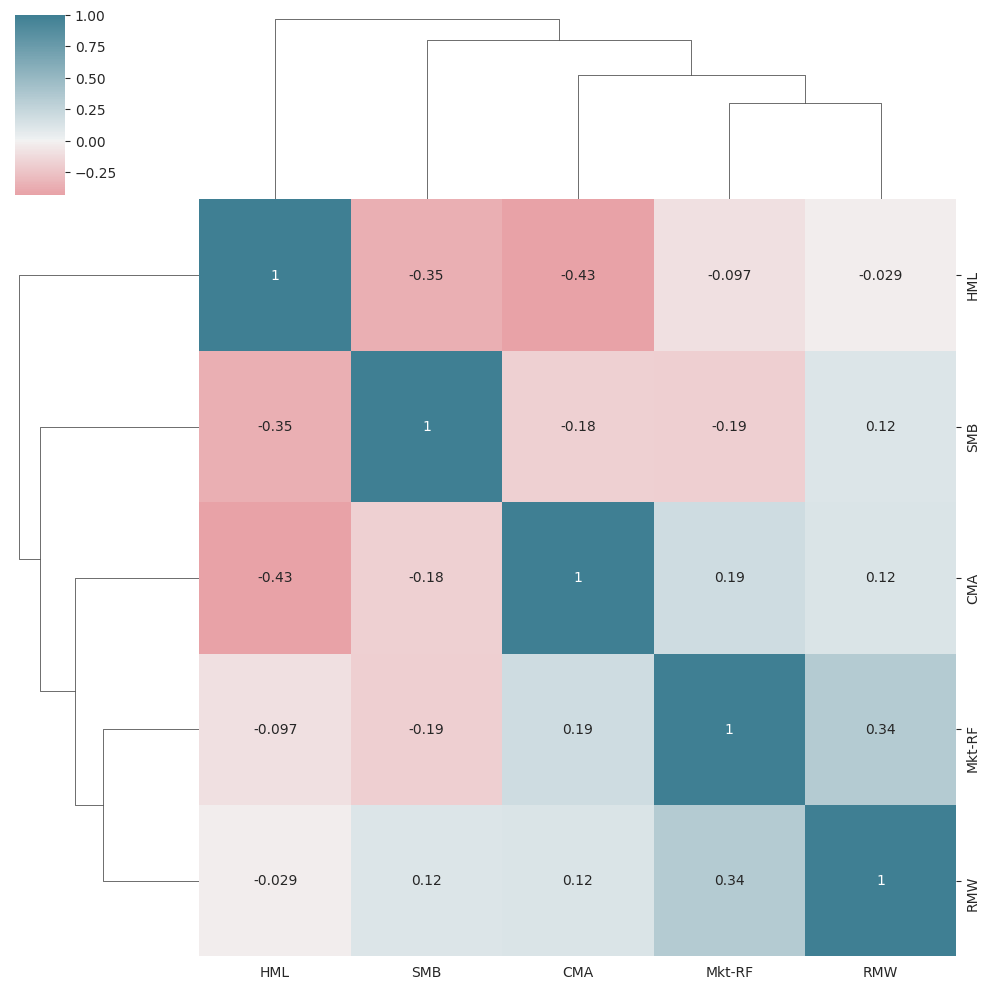

In [240]:
cmap = sns.diverging_palette(10, 220, as_cmap=True)
sns.clustermap(betas.corr(), annot=True, cmap=cmap, center=0);

In [59]:
betas.info()


<class 'pandas.core.frame.DataFrame'>
MultiIndex: 11258 entries, ('IYR', Timestamp('2005-01-02 00:00:00+0000', tz='UTC')) to ('XLY', Timestamp('2024-09-01 00:00:00+0000', tz='UTC'))
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Mkt-RF  10125 non-null  float64
 1   SMB     10125 non-null  float64
 2   HML     10125 non-null  float64
 3   RMW     10125 non-null  float64
 4   CMA     10125 non-null  float64
dtypes: float64(5)
memory usage: 515.6+ KB


In [60]:
betas.tail(20)

Mkt-RF       SMB       HML       RMW  \
ticker date                                                                
XLY    2024-04-21 00:00:00+00:00  0.082128 -0.033749 -0.305419 -0.563484   
       2024-04-28 00:00:00+00:00  0.056028 -0.146010  0.003498 -0.563997   
       2024-05-05 00:00:00+00:00  0.061955 -0.113915  0.008399 -0.500355   
       2024-05-12 00:00:00+00:00  0.061955 -0.113915  0.008399 -0.500355   
       2024-05-19 00:00:00+00:00  0.061955 -0.113915  0.008399 -0.500355   
       2024-05-26 00:00:00+00:00  0.061955 -0.113915  0.008399 -0.500355   
       2024-06-02 00:00:00+00:00  0.085237 -0.159619  0.053657 -0.538060   
       2024-06-09 00:00:00+00:00  0.085237 -0.159619  0.053657 -0.538060   
       2024-06-16 00:00:00+00:00  0.085237 -0.159619  0.053657 -0.538060   
       2024-06-23 00:00:00+00:00  0.085237 -0.159619  0.053657 -0.538060   
       2024-06-30 00:00:00+00:00  0.134297 -0.094660  0.099153 -0.432344   
       2024-07-07 00:00:00+00:00  0.111105  0.016151  0.113021 -0.362290   
       2024-07-14 00:00:00+00:00  0.111105  0.016151  0.113021 -0.362290   
       2024-07-21 00:00:00+00:00  0.111105  0.016151  0.113021 -0.362290   
       2024-07-28 00:00:00+00:00  0.111105  0.016151  0.113021 -0.362290   
       2024-08-04 00:00:00+00:00  0.080660  0.075211  0.105297 -0.386506   
       2024-08-11 00:00:00+00:00  0.080660  0.075211  0.105297 -0.386506   
       2024-08-18 00:00:00+00:00  0.080660  0.075211  0.105297 -0.386506   
       2024-08-25 00:00:00+00:00  0.080660  0.075211  0.105297 -0.386506   
       2024-09-01 00:00:00+00:00 -0.029216  0.043051  0.174060 -0.504180   

                                       CMA  
ticker date                                 
XLY    2024-04-21 00:00:00+00:00  0.398511  
       2024-04-28 00:00:00+00:00  0.215303  
       2024-05-05 00:00:00+00:00  0.178028  
       2024-05-12 00:00:00+00:00  0.178028  
       2024-05-19 00:00:00+00:00  0.178028  
       2024-05-26 00:00:00+00:00  0.178028  
       2024-06-02 00:00:00+00:00  0.171885  
       2024-06-09 00:00:00+00:00  0.171885  
       2024-06-16 00:00:00+00:00  0.171885  
       2024-06-23 00:00:00+00:00  0.171885  
       2024-06-30 00:00:00+00:00 -0.051421  
       2024-07-07 00:00:00+00:00 -0.088828  
       2024-07-14 00:00:00+00:00 -0.088828  
       2024-07-21 00:00:00+00:00 -0.088828  
       2024-07-28 00:00:00+00:00 -0.088828  
       2024-08-04 00:00:00+00:00 -0.095875  
       2024-08-11 00:00:00+00:00 -0.095875  
       2024-08-18 00:00:00+00:00 -0.095875  
       2024-08-25 00:00:00+00:00 -0.095875  
       2024-09-01 00:00:00+00:00 -0.136413

In [61]:
#betasc=betas.copy()

In [62]:
'''# Añade dos semanas a cada fecha en tu índice ya que no estan disponibles en el momento de consulta

# Obtén el nivel 'date' del índice
dates = betas.index.get_level_values('date')

# Añade dos semanas a cada fecha
new_dates = dates + pd.DateOffset(weeks=10)

# Crea un nuevo MultiIndex con las nuevas fechas
new_index = pd.MultiIndex.from_arrays([betas.index.get_level_values('ticker'), new_dates], names=['ticker', 'date'])

# Asigna el nuevo índice a tu DataFrame
betas.index = new_index
'''

"# Añade dos semanas a cada fecha en tu índice ya que no estan disponibles en el momento de consulta\n\n# Obtén el nivel 'date' del índice\ndates = betas.index.get_level_values('date')\n\n# Añade dos semanas a cada fecha\nnew_dates = dates + pd.DateOffset(weeks=10)\n\n# Crea un nuevo MultiIndex con las nuevas fechas\nnew_index = pd.MultiIndex.from_arrays([betas.index.get_level_values('ticker'), new_dates], names=['ticker', 'date'])\n\n# Asigna el nuevo índice a tu DataFrame\nbetas.index = new_index\n"

In [63]:
betas.tail()

Mkt-RF       SMB       HML       RMW  \
ticker date                                                                
XLY    2024-08-04 00:00:00+00:00  0.080660  0.075211  0.105297 -0.386506   
       2024-08-11 00:00:00+00:00  0.080660  0.075211  0.105297 -0.386506   
       2024-08-18 00:00:00+00:00  0.080660  0.075211  0.105297 -0.386506   
       2024-08-25 00:00:00+00:00  0.080660  0.075211  0.105297 -0.386506   
       2024-09-01 00:00:00+00:00 -0.029216  0.043051  0.174060 -0.504180   

                                       CMA  
ticker date                                 
XLY    2024-08-04 00:00:00+00:00 -0.095875  
       2024-08-11 00:00:00+00:00 -0.095875  
       2024-08-18 00:00:00+00:00 -0.095875  
       2024-08-25 00:00:00+00:00 -0.095875  
       2024-09-01 00:00:00+00:00 -0.136413

In [64]:
#incorporamos los cambios en los datos de betas
#for columna in betas.columns:
#    betas[columna + '_diff'] = betas[columna].diff()

In [65]:
#stop

In [66]:
data = (data
        .join(betas
              .groupby(level='ticker')
              .shift()))
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 11368 entries, ('IYR', Timestamp('2005-01-02 00:00:00+0000', tz='UTC')) to ('XLY', Timestamp('2024-11-10 00:00:00+0000', tz='UTC'))
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   return_01w  10796 non-null  float64
 1   return_02w  10796 non-null  float64
 2   return_03w  10796 non-null  float64
 3   return_06w  10796 non-null  float64
 4   return_12w  10796 non-null  float64
 5   return_52w  10796 non-null  float64
 6   Mkt-RF      10114 non-null  float64
 7   SMB         10114 non-null  float64
 8   HML         10114 non-null  float64
 9   RMW         10114 non-null  float64
 10  CMA         10114 non-null  float64
dtypes: float64(11)
memory usage: 1.3+ MB


### Impute mean for missing factor betas

In [67]:
data.loc[:, factors] = data.groupby('ticker')[factors].transform(lambda x: x.fillna(x.mean()))
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 11368 entries, ('IYR', Timestamp('2005-01-02 00:00:00+0000', tz='UTC')) to ('XLY', Timestamp('2024-11-10 00:00:00+0000', tz='UTC'))
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   return_01w  10796 non-null  float64
 1   return_02w  10796 non-null  float64
 2   return_03w  10796 non-null  float64
 3   return_06w  10796 non-null  float64
 4   return_12w  10796 non-null  float64
 5   return_52w  10796 non-null  float64
 6   Mkt-RF      11368 non-null  float64
 7   SMB         11368 non-null  float64
 8   HML         11368 non-null  float64
 9   RMW         11368 non-null  float64
 10  CMA         11368 non-null  float64
dtypes: float64(11)
memory usage: 1.3+ MB


## Momentum factors

We can use these results to compute momentum factors based on the difference between returns over longer periods and the most recent monthly return, as well as for the difference between 3 and 12 month returns as follows:

In [68]:
#for lag in [2,3,6,9,12]:
for lag in [2,3,6,12, 52]: #para semanas
    data[f'momentum_{lag:02d}'] = data[f'return_{lag:02d}w'].sub(data.return_01w)
data[f'momentum_3_12'] = data[f'return_12w'].sub(data.return_03w)

## Date Indicators

In [69]:
dates = data.index.get_level_values('date')
#data['year'] = dates.year
data['month'] = dates.month

## Sector

In [70]:
data.tail()

return_01w  return_02w  return_03w  \
ticker date                                                            
XLY    2024-10-13 00:00:00+00:00   -0.322125   -0.584217   -0.012906   
       2024-10-20 00:00:00+00:00    0.598962    0.184331   -0.153487   
       2024-10-27 00:00:00+00:00    0.272775    0.603609    0.314754   
       2024-11-03 00:00:00+00:00   -0.151096    0.085199    0.439005   
       2024-11-10 00:00:00+00:00    3.429767    2.088425    1.887324   

                                  return_06w  return_12w  return_52w  \
ticker date                                                            
XLY    2024-10-13 00:00:00+00:00    0.867230    0.765330    2.879142   
       2024-10-20 00:00:00+00:00    1.611845    1.528420    3.700774   
       2024-10-27 00:00:00+00:00    0.787833    2.428620    3.965846   
       2024-11-03 00:00:00+00:00    0.350318    2.748245    3.008444   
       2024-11-10 00:00:00+00:00    1.415381    3.212908    3.877569   

                                    Mkt-RF      SMB       HML       RMW  \
ticker date                                                               
XLY    2024-10-13 00:00:00+00:00  0.072112  0.04019  0.075017 -0.132833   
       2024-10-20 00:00:00+00:00  0.072112  0.04019  0.075017 -0.132833   
       2024-10-27 00:00:00+00:00  0.072112  0.04019  0.075017 -0.132833   
       2024-11-03 00:00:00+00:00  0.072112  0.04019  0.075017 -0.132833   
       2024-11-10 00:00:00+00:00  0.072112  0.04019  0.075017 -0.132833   

                                       CMA  momentum_02  momentum_03  \
ticker date                                                            
XLY    2024-10-13 00:00:00+00:00 -0.071884    -0.262091     0.309219   
       2024-10-20 00:00:00+00:00 -0.071884    -0.414630    -0.752449   
       2024-10-27 00:00:00+00:00 -0.071884     0.330834     0.041979   
       2024-11-03 00:00:00+00:00 -0.071884     0.236295     0.590102   
       2024-11-10 00:00:00+00:00 -0.071884    -1.341342    -1.542443   

                                  momentum_06  momentum_12  momentum_52  \
ticker date                                                               
XLY    2024-10-13 00:00:00+00:00     1.189356     1.087455     3.201267   
       2024-10-20 00:00:00+00:00     1.012883     0.929458     3.101813   
       2024-10-27 00:00:00+00:00     0.515058     2.155845     3.693071   
       2024-11-03 00:00:00+00:00     0.501415     2.899342     3.159540   
       2024-11-10 00:00:00+00:00    -2.014386    -0.216860     0.447802   

                                  momentum_3_12  month  
ticker date                                             
XLY    2024-10-13 00:00:00+00:00       0.778236     10  
       2024-10-20 00:00:00+00:00       1.681907     10  
       2024-10-27 00:00:00+00:00       2.113867     10  
       2024-11-03 00:00:00+00:00       2.309240     11  
       2024-11-10 00:00:00+00:00       1.325584     11

In [71]:
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 11368 entries, ('IYR', Timestamp('2005-01-02 00:00:00+0000', tz='UTC')) to ('XLY', Timestamp('2024-11-10 00:00:00+0000', tz='UTC'))
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   return_01w     10796 non-null  float64
 1   return_02w     10796 non-null  float64
 2   return_03w     10796 non-null  float64
 3   return_06w     10796 non-null  float64
 4   return_12w     10796 non-null  float64
 5   return_52w     10796 non-null  float64
 6   Mkt-RF         11368 non-null  float64
 7   SMB            11368 non-null  float64
 8   HML            11368 non-null  float64
 9   RMW            11368 non-null  float64
 10  CMA            11368 non-null  float64
 11  momentum_02    10796 non-null  float64
 12  momentum_03    10796 non-null  float64
 13  momentum_06    10796 non-null  float64
 14  momentum_12    10796 non-null  float64
 15  momentum_52    10796 non-null  f

In [72]:
data.index

MultiIndex([('IYR', '2005-01-02 00:00:00+00:00'),
            ('IYR', '2005-01-09 00:00:00+00:00'),
            ('IYR', '2005-01-16 00:00:00+00:00'),
            ('IYR', '2005-01-23 00:00:00+00:00'),
            ('IYR', '2005-01-30 00:00:00+00:00'),
            ('IYR', '2005-02-06 00:00:00+00:00'),
            ('IYR', '2005-02-13 00:00:00+00:00'),
            ('IYR', '2005-02-20 00:00:00+00:00'),
            ('IYR', '2005-02-27 00:00:00+00:00'),
            ('IYR', '2005-03-06 00:00:00+00:00'),
            ...
            ('XLY', '2024-09-08 00:00:00+00:00'),
            ('XLY', '2024-09-15 00:00:00+00:00'),
            ('XLY', '2024-09-22 00:00:00+00:00'),
            ('XLY', '2024-09-29 00:00:00+00:00'),
            ('XLY', '2024-10-06 00:00:00+00:00'),
            ('XLY', '2024-10-13 00:00:00+00:00'),
            ('XLY', '2024-10-20 00:00:00+00:00'),
            ('XLY', '2024-10-27 00:00:00+00:00'),
            ('XLY', '2024-11-03 00:00:00+00:00'),
            ('XLY', '2024-11-10 00

In [73]:
# Crear una Serie con el índice del DataFrame y los valores del nivel 'ticker'
ticker_series = pd.Series(data.index.get_level_values('ticker'), index=data.index)

# Usar esta Serie para llenar los valores NA
data['sector'] = ticker_series

In [74]:
data['sector'] 

ticker  date                     
IYR     2005-01-02 00:00:00+00:00    IYR
        2005-01-09 00:00:00+00:00    IYR
        2005-01-16 00:00:00+00:00    IYR
        2005-01-23 00:00:00+00:00    IYR
        2005-01-30 00:00:00+00:00    IYR
                                    ... 
XLY     2024-10-13 00:00:00+00:00    XLY
        2024-10-20 00:00:00+00:00    XLY
        2024-10-27 00:00:00+00:00    XLY
        2024-11-03 00:00:00+00:00    XLY
        2024-11-10 00:00:00+00:00    XLY
Name: sector, Length: 11368, dtype: object

In [75]:
data['sector'] 

ticker  date                     
IYR     2005-01-02 00:00:00+00:00    IYR
        2005-01-09 00:00:00+00:00    IYR
        2005-01-16 00:00:00+00:00    IYR
        2005-01-23 00:00:00+00:00    IYR
        2005-01-30 00:00:00+00:00    IYR
                                    ... 
XLY     2024-10-13 00:00:00+00:00    XLY
        2024-10-20 00:00:00+00:00    XLY
        2024-10-27 00:00:00+00:00    XLY
        2024-11-03 00:00:00+00:00    XLY
        2024-11-10 00:00:00+00:00    XLY
Name: sector, Length: 11368, dtype: object

In [76]:
data['sector'].unique()

array(['IYR', 'VOX', 'XLB', 'XLE', 'XLF', 'XLI', 'XLK', 'XLP', 'XLU',
       'XLV', 'XLY'], dtype=object)

In [77]:
data[data['sector'].isna()].index.get_level_values(0).unique()


Index([], dtype='object', name='ticker')

In [78]:
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 11368 entries, ('IYR', Timestamp('2005-01-02 00:00:00+0000', tz='UTC')) to ('XLY', Timestamp('2024-11-10 00:00:00+0000', tz='UTC'))
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   return_01w     10796 non-null  float64
 1   return_02w     10796 non-null  float64
 2   return_03w     10796 non-null  float64
 3   return_06w     10796 non-null  float64
 4   return_12w     10796 non-null  float64
 5   return_52w     10796 non-null  float64
 6   Mkt-RF         11368 non-null  float64
 7   SMB            11368 non-null  float64
 8   HML            11368 non-null  float64
 9   RMW            11368 non-null  float64
 10  CMA            11368 non-null  float64
 11  momentum_02    10796 non-null  float64
 12  momentum_03    10796 non-null  float64
 13  momentum_06    10796 non-null  float64
 14  momentum_12    10796 non-null  float64
 15  momentum_52    10796 non-null  f

## Lagged returns

To use lagged values as input variables or features associated with the current observations, we use the .shift() method to move historical returns up to the current period:

In [79]:
for t in range(1, 7):
    data[f'return_01w_t-{t}'] = data.groupby(level='ticker').return_01w.shift(t)
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 11368 entries, ('IYR', Timestamp('2005-01-02 00:00:00+0000', tz='UTC')) to ('XLY', Timestamp('2024-11-10 00:00:00+0000', tz='UTC'))
Data columns (total 25 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   return_01w      10796 non-null  float64
 1   return_02w      10796 non-null  float64
 2   return_03w      10796 non-null  float64
 3   return_06w      10796 non-null  float64
 4   return_12w      10796 non-null  float64
 5   return_52w      10796 non-null  float64
 6   Mkt-RF          11368 non-null  float64
 7   SMB             11368 non-null  float64
 8   HML             11368 non-null  float64
 9   RMW             11368 non-null  float64
 10  CMA             11368 non-null  float64
 11  momentum_02     10796 non-null  float64
 12  momentum_03     10796 non-null  float64
 13  momentum_06     10796 non-null  float64
 14  momentum_12     10796 non-null  float64
 15  momentum_52    

## Target: Holding Period Returns

Similarly, to compute returns for various holding periods, we use the normalized period returns computed previously and shift them back to align them with the current financial features

In [80]:
for t in [1,2,3,6,12]:
    data[f'target_{t:02d}w'] = data.groupby(level='ticker')[f'return_{t:02d}w'].shift(-t)

In [81]:
cols = ['target_01w',
        'target_02w',
        'target_03w', 
        'return_01w',
        'return_02w',
        'return_03w',
        'return_01w_t-1',
        'return_01w_t-2',
        'return_01w_t-3']

data[cols].dropna().sort_index().head(10)

target_01w  target_02w  target_03w  \
ticker date                                                            
IYR    2006-01-22 00:00:00+00:00    1.270808    0.553379    0.337637   
       2006-01-29 00:00:00+00:00   -0.575006   -0.602205    0.413507   
       2006-02-05 00:00:00+00:00   -0.178990    0.981416    0.973951   
       2006-02-12 00:00:00+00:00    1.420270    1.327317    0.919983   
       2006-02-19 00:00:00+00:00    0.251206    0.000000    0.752248   
       2006-02-26 00:00:00+00:00   -0.250626    0.709116    1.849323   
       2006-03-05 00:00:00+00:00    1.153999    2.447349    1.100204   
       2006-03-12 00:00:00+00:00    1.950478    0.419929    0.696529   
       2006-03-19 00:00:00+00:00   -1.301237   -0.681337   -1.681710   
       2006-03-26 00:00:00+00:00    0.476425   -0.881642   -1.533565   

                                  return_01w  return_02w  return_03w  \
ticker date                                                            
IYR    2006-01-22 00:00:00+00:00   -0.145662   -0.168136    1.181677   
       2006-01-29 00:00:00+00:00    1.270808    0.895114    0.692930   
       2006-02-05 00:00:00+00:00   -0.575006    0.553379    0.357399   
       2006-02-12 00:00:00+00:00   -0.178990   -0.602205    0.337637   
       2006-02-19 00:00:00+00:00    1.420270    0.981416    0.413507   
       2006-02-26 00:00:00+00:00    0.251206    1.327317    0.973951   
       2006-03-05 00:00:00+00:00   -0.250626    0.000000    0.919983   
       2006-03-12 00:00:00+00:00    1.153999    0.709116    0.752248   
       2006-03-19 00:00:00+00:00    1.950478    2.447349    1.849323   
       2006-03-26 00:00:00+00:00   -1.301237    0.419929    1.100204   

                                  return_01w_t-1  return_01w_t-2  \
ticker date                                                        
IYR    2006-01-22 00:00:00+00:00       -0.063245        2.018019   
       2006-01-29 00:00:00+00:00       -0.145662       -0.063245   
       2006-02-05 00:00:00+00:00        1.270808       -0.145662   
       2006-02-12 00:00:00+00:00       -0.575006        1.270808   
       2006-02-19 00:00:00+00:00       -0.178990       -0.575006   
       2006-02-26 00:00:00+00:00        1.420270       -0.178990   
       2006-03-05 00:00:00+00:00        0.251206        1.420270   
       2006-03-12 00:00:00+00:00       -0.250626        0.251206   
       2006-03-19 00:00:00+00:00        1.153999       -0.250626   
       2006-03-26 00:00:00+00:00        1.950478        1.153999   

                                  return_01w_t-3  
ticker date                                       
IYR    2006-01-22 00:00:00+00:00       -0.738228  
       2006-01-29 00:00:00+00:00        2.018019  
       2006-02-05 00:00:00+00:00       -0.063245  
       2006-02-12 00:00:00+00:00       -0.145662  
       2006-02-19 00:00:00+00:00        1.270808  
       2006-02-26 00:00:00+00:00       -0.575006  
       2006-03-05 00:00:00+00:00       -0.178990  
       2006-03-12 00:00:00+00:00        1.420270  
       2006-03-19 00:00:00+00:00        0.251206  
       2006-03-26 00:00:00+00:00       -0.250626

In [82]:
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 11368 entries, ('IYR', Timestamp('2005-01-02 00:00:00+0000', tz='UTC')) to ('XLY', Timestamp('2024-11-10 00:00:00+0000', tz='UTC'))
Data columns (total 30 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   return_01w      10796 non-null  float64
 1   return_02w      10796 non-null  float64
 2   return_03w      10796 non-null  float64
 3   return_06w      10796 non-null  float64
 4   return_12w      10796 non-null  float64
 5   return_52w      10796 non-null  float64
 6   Mkt-RF          11368 non-null  float64
 7   SMB             11368 non-null  float64
 8   HML             11368 non-null  float64
 9   RMW             11368 non-null  float64
 10  CMA             11368 non-null  float64
 11  momentum_02     10796 non-null  float64
 12  momentum_03     10796 non-null  float64
 13  momentum_06     10796 non-null  float64
 14  momentum_12     10796 non-null  float64
 15  momentum_52    

Market cap information is tied to currrent prices. We create an adjustment factor to have the values reflect lower historical prices for each individual stock:

In [83]:
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 11368 entries, ('IYR', Timestamp('2005-01-02 00:00:00+0000', tz='UTC')) to ('XLY', Timestamp('2024-11-10 00:00:00+0000', tz='UTC'))
Data columns (total 30 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   return_01w      10796 non-null  float64
 1   return_02w      10796 non-null  float64
 2   return_03w      10796 non-null  float64
 3   return_06w      10796 non-null  float64
 4   return_12w      10796 non-null  float64
 5   return_52w      10796 non-null  float64
 6   Mkt-RF          11368 non-null  float64
 7   SMB             11368 non-null  float64
 8   HML             11368 non-null  float64
 9   RMW             11368 non-null  float64
 10  CMA             11368 non-null  float64
 11  momentum_02     10796 non-null  float64
 12  momentum_03     10796 non-null  float64
 13  momentum_06     10796 non-null  float64
 14  momentum_12     10796 non-null  float64
 15  momentum_52    

## The Data: Recessions & Leading Indicators

We will use a small and simple dataset so we can focus on the workflow. We use the Federal Reserve’s Economic Data (FRED) service (see Chapter 2) to download the US recession dates as defined by the National Bureau of Economic Research. We also source four variables that are commonly used to predict the onset of a recession (Kelley 2019) and available via FRED, namely:

The long-term spread of the treasury yield curve, defined as the difference between the ten-year and the three-month Treasury yield.
The University of Michigan’s consumer sentiment indicator
The National Financial Conditions Index (NFCI), and
The NFCI nonfinancial leverage subindex.

### Download from FRED

In [84]:
indicators = (['JHDUSRGDPBR', 'T10Y3M', 'BAMLC0A0CM','BAMLH0A0HYM2','BAMLHE00EHYIOAS', 'UMCSENT','UNRATE','GDPC1','DCOILWTICO',
               'CORESTICKM159SFRBATL','USSLIND',
               'VIXCLS','OVXCLS','ICSA','MARTSMPCSM44000USS','RSXFS','TREAST','DGS1'])
var_names = (['recession', 'yield_curve', 'corp_oas', 'hy_oas','eu_hy_oas', 'sentiment','empleo','real_gdp','oil',
              'inflacion','leading',
              'vix','vixoil','weekjobclaims','retail_sales_percent','retail_sales','us_asset_balance','1y_yield'])

In [85]:
features = var_names[1:]
label = var_names[0]

In [86]:
var_display = (['Recession', 'Yield Curve', 'corp_oas', 'hy_oas','eu_hy_oas' , 'Sentiment','empleo','real_gdp','oil','inflacion',
              'leading','vix','vixoil','weekjobclaims','retail_sales_percent',
                'retail_sales','us_asset_balance','1y_yield'])
col_dict = dict(zip(var_names, var_display))

In [87]:
data_fred = (web.DataReader(indicators, 'fred', 1980, END+1)
        .ffill()
        #.resample('M')
        #.resample('W-WED')
        .resample('W')
        .last()
        .dropna())
data_fred.columns = var_names

In [88]:
data_fred.tail(20)

,recession,yield_curve,corp_oas,hy_oas,eu_hy_oas,sentiment,empleo,real_gdp,oil,inflacion,leading,vix,vixoil,weekjobclaims,retail_sales_percent,retail_sales,us_asset_balance,1y_yield
DATE,,,,,,,,,,,,,,,,,,
2024-06-30,0.0,-1.12,0.96,3.21,3.53,68.2,4.1,23223.906,82.83,4.226876,1.72,12.44,26.54,239000.0,-0.3,607986.0,4453571.0,5.09
2024-07-07,0.0,-1.18,0.92,3.27,3.36,66.4,4.3,23386.248,84.44,4.164951,1.72,12.48,23.78,223000.0,1.3,615960.0,4437894.0,4.98
2024-07-14,0.0,-1.25,0.92,3.19,3.36,66.4,4.3,23386.248,83.49,4.164951,1.72,12.46,24.12,245000.0,1.3,615960.0,4438095.0,4.87
2024-07-21,0.0,-1.18,0.93,3.09,3.39,66.4,4.3,23386.248,81.43,4.164951,1.72,16.52,26.83,235000.0,1.3,615960.0,4423552.0,4.87
2024-07-28,0.0,-1.18,0.95,3.10,3.47,66.4,4.3,23386.248,78.58,4.164951,1.72,16.39,29.77,250000.0,1.3,615960.0,4423725.0,4.79
2024-08-04,0.0,-1.49,1.06,3.72,3.79,67.9,4.2,23386.248,74.99,4.103706,1.72,23.39,38.83,234000.0,0.0,615891.0,4413615.0,4.33
2024-08-11,0.0,-1.39,1.05,3.49,3.79,67.9,4.2,23386.248,78.28,4.103706,1.72,20.37,33.37,228000.0,0.0,615891.0,4413650.0,4.50
2024-08-18,0.0,-1.44,0.98,3.29,3.59,67.9,4.2,23386.248,78.05,4.103706,1.72,14.80,31.00,233000.0,0.0,615891.0,4413685.0,4.49
2024-08-25,0.0,-1.44,0.96,3.19,3.59,67.9,4.2,23386.248,75.82,4.103706,1.72,15.86,30.54,232000.0,0.0,615891.0,4398736.0,4.36


We standardize the features so all have mean 0 standard deviation of 1:

In [89]:
#data_fred.loc[:, features] = scale(data_fred.loc[:, features])

In [90]:
data_fred.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 914 entries, 2007-05-13 to 2024-11-10
Freq: W-SUN
Data columns (total 18 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   recession             914 non-null    float64
 1   yield_curve           914 non-null    float64
 2   corp_oas              914 non-null    float64
 3   hy_oas                914 non-null    float64
 4   eu_hy_oas             914 non-null    float64
 5   sentiment             914 non-null    float64
 6   empleo                914 non-null    float64
 7   real_gdp              914 non-null    float64
 8   oil                   914 non-null    float64
 9   inflacion             914 non-null    float64
 10  leading               914 non-null    float64
 11  vix                   914 non-null    float64
 12  vixoil                914 non-null    float64
 13  weekjobclaims         914 non-null    float64
 14  retail_sales_percent  914 non-null    float

In [91]:
data_fred.index.name = 'date'

In [92]:
'''# Añade  semanas a cada fecha en tu índice ya que no estan disponibles en el momento de consulta

# Añade dos semanas a cada fecha en tu índice
data_fred.index = data_fred.index + pd.DateOffset(weeks=1)
'''

'# Añade  semanas a cada fecha en tu índice ya que no estan disponibles en el momento de consulta\n\n# Añade dos semanas a cada fecha en tu índice\ndata_fred.index = data_fred.index + pd.DateOffset(weeks=1)\n'

In [93]:
data_fred.tail()

,recession,yield_curve,corp_oas,hy_oas,eu_hy_oas,sentiment,empleo,real_gdp,oil,inflacion,leading,vix,vixoil,weekjobclaims,retail_sales_percent,retail_sales,us_asset_balance,1y_yield
date,,,,,,,,,,,,,,,,,,
2024-10-13,0.0,-0.65,0.84,2.98,3.29,70.1,4.1,23386.248,76.11,4.010873,1.72,20.46,52.68,242000.0,0.3,617958.0,4364466.0,4.18
2024-10-20,0.0,-0.65,0.83,2.88,3.27,70.1,4.1,23386.248,69.78,4.010873,1.72,18.03,47.22,228000.0,0.3,617958.0,4357572.0,4.19
2024-10-27,0.0,-0.48,0.85,2.89,3.24,70.1,4.1,23386.248,72.02,4.010873,1.72,20.33,48.97,218000.0,0.3,617958.0,4357656.0,4.29
2024-11-03,0.0,-0.24,0.86,2.83,3.19,70.1,4.1,23386.248,69.81,4.010873,1.72,21.88,44.14,221000.0,0.3,617958.0,4357825.0,4.28
2024-11-10,0.0,-0.33,0.78,2.73,3.20,70.1,4.1,23386.248,71.83,4.010873,1.72,15.20,42.55,221000.0,0.3,617958.0,4339963.0,4.28


In [94]:
data_fred.tail()

,recession,yield_curve,corp_oas,hy_oas,eu_hy_oas,sentiment,empleo,real_gdp,oil,inflacion,leading,vix,vixoil,weekjobclaims,retail_sales_percent,retail_sales,us_asset_balance,1y_yield
date,,,,,,,,,,,,,,,,,,
2024-10-13,0.0,-0.65,0.84,2.98,3.29,70.1,4.1,23386.248,76.11,4.010873,1.72,20.46,52.68,242000.0,0.3,617958.0,4364466.0,4.18
2024-10-20,0.0,-0.65,0.83,2.88,3.27,70.1,4.1,23386.248,69.78,4.010873,1.72,18.03,47.22,228000.0,0.3,617958.0,4357572.0,4.19
2024-10-27,0.0,-0.48,0.85,2.89,3.24,70.1,4.1,23386.248,72.02,4.010873,1.72,20.33,48.97,218000.0,0.3,617958.0,4357656.0,4.29
2024-11-03,0.0,-0.24,0.86,2.83,3.19,70.1,4.1,23386.248,69.81,4.010873,1.72,21.88,44.14,221000.0,0.3,617958.0,4357825.0,4.28
2024-11-10,0.0,-0.33,0.78,2.73,3.20,70.1,4.1,23386.248,71.83,4.010873,1.72,15.20,42.55,221000.0,0.3,617958.0,4339963.0,4.28


In [95]:
#incorporamos los cambios en los datos
for columna in data_fred.columns:
    data_fred[columna + '_diff'] = data_fred[columna].diff()

In [96]:
#eliminamos algunas variables que tienen mucha dependencia del nivel historico
data_fred = data_fred.drop(['empleo','us_asset_balance'], axis=1)

In [97]:
data_fred.tail(20)

,recession,yield_curve,corp_oas,hy_oas,eu_hy_oas,sentiment,real_gdp,oil,inflacion,leading,...,oil_diff,inflacion_diff,leading_diff,vix_diff,vixoil_diff,weekjobclaims_diff,retail_sales_percent_diff,retail_sales_diff,us_asset_balance_diff,1y_yield_diff
date,,,,,,,,,,,,,,,,,,,,,
2024-06-30,0.0,-1.12,0.96,3.21,3.53,68.2,23223.906,82.83,4.226876,1.72,...,1.12,0.000000,0.0,-0.76,1.80,5000.0,0.0,0.0,500.0,-0.01
2024-07-07,0.0,-1.18,0.92,3.27,3.36,66.4,23386.248,84.44,4.164951,1.72,...,1.61,-0.061925,0.0,0.04,-2.76,-16000.0,1.6,7974.0,-15677.0,-0.11
2024-07-14,0.0,-1.25,0.92,3.19,3.36,66.4,23386.248,83.49,4.164951,1.72,...,-0.95,0.000000,0.0,-0.02,0.34,22000.0,0.0,0.0,201.0,-0.11
2024-07-21,0.0,-1.18,0.93,3.09,3.39,66.4,23386.248,81.43,4.164951,1.72,...,-2.06,0.000000,0.0,4.06,2.71,-10000.0,0.0,0.0,-14543.0,0.00
2024-07-28,0.0,-1.18,0.95,3.10,3.47,66.4,23386.248,78.58,4.164951,1.72,...,-2.85,0.000000,0.0,-0.13,2.94,15000.0,0.0,0.0,173.0,-0.08
2024-08-04,0.0,-1.49,1.06,3.72,3.79,67.9,23386.248,74.99,4.103706,1.72,...,-3.59,-0.061245,0.0,7.00,9.06,-16000.0,-1.3,-69.0,-10110.0,-0.46
2024-08-11,0.0,-1.39,1.05,3.49,3.79,67.9,23386.248,78.28,4.103706,1.72,...,3.29,0.000000,0.0,-3.02,-5.46,-6000.0,0.0,0.0,35.0,0.17
2024-08-18,0.0,-1.44,0.98,3.29,3.59,67.9,23386.248,78.05,4.103706,1.72,...,-0.23,0.000000,0.0,-5.57,-2.37,5000.0,0.0,0.0,35.0,-0.01
2024-08-25,0.0,-1.44,0.96,3.19,3.59,67.9,23386.248,75.82,4.103706,1.72,...,-2.23,0.000000,0.0,1.06,-0.46,-1000.0,0.0,0.0,-14949.0,-0.13


In [98]:
#data_fred.index = data_fred.index.to_timestamp()
data_fred.index.name = 'date'

In [99]:
data_fred.index = data_fred.index.tz_localize('UTC')


data = (data
        .join(data_fred))
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 11368 entries, ('IYR', Timestamp('2005-01-02 00:00:00+0000', tz='UTC')) to ('XLY', Timestamp('2024-11-10 00:00:00+0000', tz='UTC'))
Data columns (total 64 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   return_01w                 10796 non-null  float64
 1   return_02w                 10796 non-null  float64
 2   return_03w                 10796 non-null  float64
 3   return_06w                 10796 non-null  float64
 4   return_12w                 10796 non-null  float64
 5   return_52w                 10796 non-null  float64
 6   Mkt-RF                     11368 non-null  float64
 7   SMB                        11368 non-null  float64
 8   HML                        11368 non-null  float64
 9   RMW                        11368 non-null  float64
 10  CMA                        11368 non-null  float64
 11  momentum_02                10796 non-null  float64
 

## Store data

We will use the data again in several later chapters, starting in [Chapter 7 on Linear Models](../../07_linear_models/README.md).

In [100]:
#DATA_STORE = '../data/assets_2.h5'

In [101]:
# Convert MultiIndex to regular index before saving
# data_save = data.copy()
# data_save.index = data_save.index.map(lambda x: f"{x[0]}_{x[1]}")
# data2_save = data2.copy() 
# data2_save.index = data2_save.index.map(lambda x: f"{x[0]}_{x[1]}")

# with pd.HDFStore(DATA_STORE) as store:
#     store.put('engineered_features', data_save.sort_index())
#     store.put('data_raw', data2_save.sort_index()) # antes de normalizado de retornos
#     print(store.info())

data.to_parquet('data/data.parquet')

In [102]:
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 11368 entries, ('IYR', Timestamp('2005-01-02 00:00:00+0000', tz='UTC')) to ('XLY', Timestamp('2024-11-10 00:00:00+0000', tz='UTC'))
Data columns (total 64 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   return_01w                 10796 non-null  float64
 1   return_02w                 10796 non-null  float64
 2   return_03w                 10796 non-null  float64
 3   return_06w                 10796 non-null  float64
 4   return_12w                 10796 non-null  float64
 5   return_52w                 10796 non-null  float64
 6   Mkt-RF                     11368 non-null  float64
 7   SMB                        11368 non-null  float64
 8   HML                        11368 non-null  float64
 9   RMW                        11368 non-null  float64
 10  CMA                        11368 non-null  float64
 11  momentum_02                10796 non-null  float64
 

In [103]:
data

return_01w  return_02w  return_03w  \
ticker date                                                            
IYR    2005-01-02 00:00:00+00:00         NaN         NaN         NaN   
       2005-01-09 00:00:00+00:00         NaN         NaN         NaN   
       2005-01-16 00:00:00+00:00         NaN         NaN         NaN   
       2005-01-23 00:00:00+00:00         NaN         NaN         NaN   
       2005-01-30 00:00:00+00:00         NaN         NaN         NaN   
...                                      ...         ...         ...   
XLY    2024-10-13 00:00:00+00:00   -0.322125   -0.584217   -0.012906   
       2024-10-20 00:00:00+00:00    0.598962    0.184331   -0.153487   
       2024-10-27 00:00:00+00:00    0.272775    0.603609    0.314754   
       2024-11-03 00:00:00+00:00   -0.151096    0.085199    0.439005   
       2024-11-10 00:00:00+00:00    3.429767    2.088425    1.887324   

                                  return_06w  return_12w  return_52w  \
ticker date                                                            
IYR    2005-01-02 00:00:00+00:00         NaN         NaN         NaN   
       2005-01-09 00:00:00+00:00         NaN         NaN         NaN   
       2005-01-16 00:00:00+00:00         NaN         NaN         NaN   
       2005-01-23 00:00:00+00:00         NaN         NaN         NaN   
       2005-01-30 00:00:00+00:00         NaN         NaN         NaN   
...                                      ...         ...         ...   
XLY    2024-10-13 00:00:00+00:00    0.867230    0.765330    2.879142   
       2024-10-20 00:00:00+00:00    1.611845    1.528420    3.700774   
       2024-10-27 00:00:00+00:00    0.787833    2.428620    3.965846   
       2024-11-03 00:00:00+00:00    0.350318    2.748245    3.008444   
       2024-11-10 00:00:00+00:00    1.415381    3.212908    3.877569   

                                    Mkt-RF       SMB       HML       RMW  ...  \
ticker date                                                               ...   
IYR    2005-01-02 00:00:00+00:00  0.100716  0.041236  0.020160 -0.045120  ...   
       2005-01-09 00:00:00+00:00  0.100716  0.041236  0.020160 -0.045120  ...   
       2005-01-16 00:00:00+00:00  0.100716  0.041236  0.020160 -0.045120  ...   
       2005-01-23 00:00:00+00:00  0.100716  0.041236  0.020160 -0.045120  ...   
       2005-01-30 00:00:00+00:00  0.100716  0.041236  0.020160 -0.045120  ...   
...                                    ...       ...       ...       ...  ...   
XLY    2024-10-13 00:00:00+00:00  0.072112  0.040190  0.075017 -0.132833  ...   
       2024-10-20 00:00:00+00:00  0.072112  0.040190  0.075017 -0.132833  ...   
       2024-10-27 00:00:00+00:00  0.072112  0.040190  0.075017 -0.132833  ...   
       2024-11-03 00:00:00+00:00  0.072112  0.040190  0.075017 -0.132833  ...   
       2024-11-10 00:00:00+00:00  0.072112  0.040190  0.075017 -0.132833  ...   

                                  oil_diff  inflacion_diff  leading_diff  \
ticker date                                                                
IYR    2005-01-02 00:00:00+00:00       NaN             NaN           NaN   
       2005-01-09 00:00:00+00:00       NaN             NaN           NaN   
       2005-01-16 00:00:00+00:00       NaN             NaN           NaN   
       2005-01-23 00:00:00+00:00       NaN             NaN           NaN   
       2005-01-30 00:00:00+00:00       NaN             NaN           NaN   
...                                    ...             ...           ...   
XLY    2024-10-13 00:00:00+00:00      1.18             0.0           0.0   
       2024-10-20 00:00:00+00:00     -6.33             0.0           0.0   
       2024-10-27 00:00:00+00:00      2.24             0.0           0.0   
       2024-11-03 00:00:00+00:00     -2.21             0.0           0.0   
       2024-11-10 00:00:00+00:00      2.02             0.0           0.0   

                                  vix_diff  vixoil_diff  weekjobclaims_diff  \
ticker date                           